In [1]:
# mount my Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# change directories
%cd ./gdrive/Othercomputers/My iMac/Data_Science/ML_EndToEnd_Projects/ml_project

/content/gdrive/Othercomputers/My iMac/Data_Science/ML_EndToEnd_Projects/ml_project


In [3]:
# install/import the dependencies
!pip install -U mrmr_selection catboost -q

from typing import Tuple, List, Dict, Any
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from yaml import SafeLoader
from mrmr import mrmr_regression
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.1 MB/s eta 0:00:00


In [4]:
# set sklearn's display configuration
set_config(display="diagram")

In [5]:
# read 'student.csv' in as a Pandas DataFrame
df = pd.read_csv(r"./notebooks/data/student.csv")

# output five random records from the 'df' DataFrame
df.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
954,female,group C,some college,standard,none,62,69,NaN
54,female,group C,some high school,free/reduced,completed,71,84,NaN
590,male,group C,some college,free/reduced,none,58,57,54.0
584,female,group D,some college,standard,none,69,77,77.0
479,male,group E,associate's degree,standard,none,76,71,NaN


In [6]:
## STEP 1: read in the parameters from ./conf/parameters.yml
def get_params(path: str) -> Dict[str, Any]:
  """
  Returns the parameters defined in path

  Args:
    path: ./conf/parameters.yml

  Returns:
    params: Parameters defined in path
  """
  with open(path) as fp:
    params = yaml.load(fp, Loader=SafeLoader)
    return params

In [7]:
parameters = get_params(r"./conf/parameters.yml")
parameters

{'target': 'math_score',
 'numeric_features': ['reading_score', 'writing_score'],
 'nominal_features': ['gender',
  'race_ethnicity',
  'lunch',
  'test_preparation_course'],
 'ordinal': {'features': ['parental_level_of_education'],
  'categories': ['some high school',
   'high school',
   'some college',
   "associate's degree",
   "bachelor's degree",
   "master's degree"]},
 'test_size': 0.2,
 'random_state': 42}

In [8]:
## STEP 2: split the data into train and test sets
def split_data(
    data: pd.DataFrame, 
    params: Dict[str, Any]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits data into train and test sets

    Args:
        data: Data containing features and target

    Returns:
        train_set: Train set with missing values
        test_set: Test set with missing values
    """
    target = params["target"]
    train_set, test_set = train_test_split(
        data, 
        test_size=params["test_size"],  
        random_state=params["random_state"]
    )

    train_set = train_set.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)
    return train_set, test_set

In [9]:
train_set, test_set = split_data(df, parameters)

In [10]:
# output five random records from the train set
train_set.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
253,male,group C,high school,standard,none,52,53,49.0
461,male,group C,some high school,standard,completed,76,80,73.0
261,female,group D,some college,standard,none,51,58,54.0
415,female,group E,master's degree,standard,completed,94,99,100.0
77,male,NaN,high school,free/reduced,none,60,57,51.0


In [11]:
# output five random records from the test set
test_set.sample(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
93,male,group B,high school,free/reduced,none,66,77,70.0
48,male,group D,some high school,standard,completed,89,88,82.0
19,female,group D,associate's degree,NaN,none,56,65,63.0
47,female,group C,high school,standard,none,29,29,30.0
88,female,group C,some high school,standard,completed,77,90,NaN


In [12]:
# train set's missing values
train_set.isna().sum()

gender                           0
race_ethnicity                 126
parental_level_of_education      0
lunch                           52
test_preparation_course         24
math_score                       0
reading_score                    0
writing_score                  103
dtype: int64

In [13]:
# test set's missing values
test_set.isna().sum()

gender                          0
race_ethnicity                 24
parental_level_of_education     0
lunch                          18
test_preparation_course         6
math_score                      0
reading_score                   0
writing_score                  27
dtype: int64

In [14]:
## STEP 3: impute the train and test set features with missing values
def impute_data(
        train_set: pd.DataFrame, 
        test_set: pd.DataFrame, 
        params: Dict[str, Any]
        ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns the imputed train and test sets

    Args:
        train_set: Train set with missing values
        test_set: Test set with missing values

    Returns:
        train_set_imputed: Train set with imputed values
        test_set_imputed: Test set with imputed values
    """
    target = params["target"]
    X_train = train_set.drop(target, axis=1)
    y_train = train_set[target]
    X_test = test_set.drop(target, axis=1)
    y_test = test_set[target]
    X_train_imputed, X_test_imputed = X_train.copy(deep=True), X_test.copy(deep=True)
    num_cols = params["numeric_features"]
    cat_cols = params["nominal_features"] + params["ordinal"]["features"]
    null_cols = [
        col
        for col in num_cols + cat_cols
        if X_train[col].isna().sum() > 0
    ]

    # label encode the non-null categorical features
    for cat_col in cat_cols:
        if cat_col not in null_cols:
            categories = sorted(set(X_train[cat_col]))
            cat_to_idx = dict(zip(categories, range(len(categories))))
            X_train[cat_col] = X_train[cat_col].map(cat_to_idx).astype("int")
            X_test[cat_col] = X_test[cat_col].map(cat_to_idx).astype("int")

    for col in null_cols:
        features = [
            feature
            for feature in num_cols + cat_cols
            if feature not in null_cols
        ]
        # categorical feature imputation
        if (col in cat_cols) or (len(set(X_train[col].dropna())) <= 10):
            features += [col]
            train = X_train[features].copy(deep=True)
            train_notna = train[train[col].notna()].copy(deep=True)
            train_isna = train[train[col].isna()].copy(deep=True)
            train_indices_to_impute = train_isna.index.tolist()
            model = RandomForestClassifier()
            model.fit(train_notna.drop(col, axis=1), train_notna[col])
            test = X_test[features].copy(deep=True)
            test_isna = test[test[col].isna()].copy(deep=True)
            test_indices_to_impute = test_isna.index.tolist()
            X_train_imputed.loc[train_indices_to_impute, col] = model.predict(train_isna.drop(col, axis=1))
            X_test_imputed.loc[test_indices_to_impute, col] = model.predict(test_isna.drop(col, axis=1))
        # numeric feature imputation
        else:
            features += [col]
            train = X_train[features].copy(deep=True)
            train_notna = train[train[col].notna()].copy(deep=True)
            train_isna = train[train[col].isna()].copy(deep=True)
            train_indices_to_impute = train_isna.index.tolist()
            model = RandomForestRegressor()
            model.fit(train_notna.drop(col, axis=1), train_notna[col])
            test = X_test[features].copy(deep=True)
            test_isna = test[test[col].isna()].copy(deep=True)
            test_indices_to_impute = test_isna.index.tolist()
            X_train_imputed.loc[train_indices_to_impute, col] = model.predict(train_isna.drop(col, axis=1))
            X_test_imputed.loc[test_indices_to_impute, col] = model.predict(test_isna.drop(col, axis=1))

    # concatenate the train and test set imputed features and target
    train_set_imputed = pd.concat([X_train_imputed, y_train], axis=1).reset_index(drop=True)
    test_set_imputed = pd.concat([X_test_imputed, y_test], axis=1).reset_index(drop=True)
    return train_set_imputed, test_set_imputed

In [15]:
train_set, test_set = impute_data(train_set, test_set, parameters)

In [16]:
# confirm that all missing values have been imputed
assert train_set.isna().sum().sum() == 0
assert test_set.isna().sum().sum() == 0

In [17]:
## STEP 4: processes the train and test set features
def process_data(
    train_set: pd.DataFrame, 
    test_set: pd.DataFrame, 
    params: Dict[str, Any]
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Returns processed train and test sets

    Args:
      train_set_imputed: Train set with imputed values  
      test_set_imputed: Test set with imputed values
      params: Parameters defined ./conf/parameters.yml 

    Returns:
      X_train: Processed train set feature matrix
      X_test: Processed test set features matrix
      y_train: Train set target vector
      y_test: Test set target vector
    """
    target = params["target"]
    X_train, y_train = train_set.drop(target, axis=1), train_set[target]
    X_test, y_test = test_set.drop(target, axis=1), test_set[target]
    
    # create a ColumnTransformer instance to transform the features
    ct = ColumnTransformer([
            (
                "numeric_features", 
                StandardScaler(), 
                params["numeric_features"]
             ), 
            (
                "nominal_features", 
                OneHotEncoder(sparse_output=False, handle_unknown="ignore"), 
                params["nominal_features"]
            ), 
            (
                "ordinal_features", 
                OrdinalEncoder(categories=[params["ordinal"]["categories"]]), 
                params["ordinal"]["features"]
            )
        ])

    # fit the ColumnTransformer instance to the train set features
    ct.fit(X_train)

    # extract the categories from the features that were one-hot encoded
    ohe_categories = []
    for arr in ct.transformers_[1][1].categories_:
      ohe_categories += [cat.lower() for cat in arr.tolist()]

    features = [
        col.replace(" ", "_").replace("/", "_") 
        for col 
        in params["numeric_features"] + ohe_categories + params["ordinal"]["features"]
    ]

    # transform the train and test set feature matrices
    X_train = pd.DataFrame(
        ct.transform(X_train), columns=features, index=X_train.index.tolist()
        )
    X_test = pd.DataFrame(
        ct.transform(X_test), columns=features, index=X_test.index.tolist()
        )
    
    # select the K most relevant, least redundant features
    rel_features = mrmr_regression(
        X=X_train, 
        y=y_train, 
        K=int(len(features)/2), 
        relevance="f", 
        redundancy="c"
        )

    # filter X_train and X_test w.r.t. the most relevant, least redundant features
    X_train = X_train[rel_features].copy(deep=True)
    X_test = X_test[rel_features].copy(deep=True)

    return X_train, X_test, y_train, y_test

In [18]:
Xtrain, Xtest, ytrain, ytest = process_data(train_set, test_set, parameters)

100%|██████████| 7/7 [00:00<00:00, 28.65it/s]


In [19]:
# confirm that all features are numeric
assert list(set(Xtrain.dtypes))[0] == np.number
assert list(set(Xtrain.dtypes))[0] == np.number

In [20]:
# output five random records from the train set feature matrix
Xtrain.sample(5)

,reading_score,writing_score,free_reduced,group_e,standard,none,female
716,-0.799516,-0.756154,1.0,1.0,0.0,1.0,1.0
30,0.238367,-0.091920,0.0,0.0,1.0,1.0,0.0
326,0.861097,1.369393,0.0,0.0,1.0,0.0,1.0
451,-0.384363,-0.889000,0.0,0.0,1.0,1.0,0.0
237,-0.384363,-0.689730,1.0,0.0,0.0,1.0,1.0


In [21]:
# output five random records from the test set feature matrix
Xtest.sample(5)

,reading_score,writing_score,free_reduced,group_e,standard,none,female
104,0.307559,-0.291190,0.0,0.0,1.0,1.0,0.0
179,0.861097,0.505890,0.0,0.0,1.0,0.0,1.0
44,1.207058,0.439467,1.0,0.0,0.0,1.0,0.0
172,1.345443,1.967204,1.0,0.0,0.0,0.0,1.0
42,-0.591940,-0.025497,0.0,0.0,1.0,0.0,0.0


In [22]:
## STEP 5: adjusted R²
def adj_rsquared(X, y, yhat) -> float:
  """
  Returns the adjusted R²

  Args:
    X: feature matrix
    y: target vector
    yhat: prediction vector

  Returns:
    adj_r2: Adjusted R²
  """
  N, D = X.shape
  t = y - np.mean(y)
  sst = t.dot(t)
  e = y - yhat
  sse = e.dot(e)
  r2 = 1 - (sse / sst)
  adj_r2 = 1 - (((1 - r2) * (N - 1)) / (N - D - 1))
  return adj_r2

In [23]:
# train, predict, and evaluate
models = {
    "LinearRegression": LinearRegression(), 
    "LassoRegression": Lasso(), 
    "RidgeRegression": Ridge(), 
    "KNeighborsRegressor": KNeighborsRegressor(),
    "SupportVectorRegression": SVR(), 
    "DecisionTreeRegressor": DecisionTreeRegressor(), 
    "RandomForestRegressor": RandomForestRegressor(), 
    "XGBRegressor": XGBRegressor(), 
    "CatBoostRegressor": CatBoostRegressor(verbose=False), 
    "AdaBoostRegressor": AdaBoostRegressor()
}

model_evaluations = {}
for name, model in models.items():
  # train the model
  model.fit(Xtrain, ytrain)

  # train set predictions and evaluation
  yhat_train = model.predict(Xtrain)
  adj_r2_train = np.round(adj_rsquared(Xtrain, ytrain, yhat_train), 4)

  # test set predictions and evaluation
  yhat_test = model.predict(Xtest)
  adj_r2_test = np.round(adj_rsquared(Xtest, ytest, yhat_test), 4)

  # map each model to its corresponding adjusted R² scores
  model_evaluations[name] = [adj_r2_train, adj_r2_test]

In [24]:
# output the 'model_evaluations' dictionary
model_evaluations

{'LinearRegression': [0.8618, 0.8792],
 'LassoRegression': [0.8026, 0.8177],
 'RidgeRegression': [0.8618, 0.8791],
 'KNeighborsRegressor': [0.8815, 0.8048],
 'SupportVectorRegression': [0.8043, 0.7185],
 'DecisionTreeRegressor': [0.9965, 0.7179],
 'RandomForestRegressor': [0.9731, 0.8302],
 'XGBRegressor': [0.9851, 0.7999],
 'CatBoostRegressor': [0.9356, 0.8452],
 'AdaBoostRegressor': [0.8411, 0.8448]}

In [25]:
# output the model with the highest test set adjusted R²
(pd.DataFrame
 .from_dict(
    model_evaluations,
    orient="index", 
    columns=["Adjusted_R²_Train", "Adjusted_R²_Test"]
 )
 .sort_values("Adjusted_R²_Test", ascending=False)
 .iloc[0, :]
 .to_frame()
 .T
 )

,Adjusted_R²_Train,Adjusted_R²_Test
LinearRegression,0.8618,0.8792


In [26]:
# sort the models w.r.t. the test set adjusted R² score, in descending order
sorted(model_evaluations.items(), key=lambda kv: kv[1][1])[::-1]

[('LinearRegression', [0.8618, 0.8792]),
 ('RidgeRegression', [0.8618, 0.8791]),
 ('CatBoostRegressor', [0.9356, 0.8452]),
 ('AdaBoostRegressor', [0.8411, 0.8448]),
 ('RandomForestRegressor', [0.9731, 0.8302]),
 ('LassoRegression', [0.8026, 0.8177]),
 ('KNeighborsRegressor', [0.8815, 0.8048]),
 ('XGBRegressor', [0.9851, 0.7999]),
 ('SupportVectorRegression', [0.8043, 0.7185]),
 ('DecisionTreeRegressor', [0.9965, 0.7179])]

In [27]:
# select and output the 'best' model
best_model_name: str = sorted(model_evaluations.items(), key=lambda kv: kv[1][1])[::-1][0][0]
best_model = models[best_model_name]
best_model

LinearRegression()

In [28]:
## STEP 6: train several regressors, select the one that produces the...
# highest test set adjusted R², and use it to make test set predictions
def train_evaluate_predict(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series) -> Tuple[pd.Series, str]:
    """
    Trains and evaluates several regressors, and selects 
    the 'best' one to generate test set predictions

    Args:
      X_train: Processed train set feature matrix
      X_test: Processed test set feature matrix
      y_train: Train set target vector
      y_test: Test set target vector

    Returns:
      yhat_test: Test set prediction vector
      best_model_name: Name of the 'best' model 
    """
    models = {
    "LinearRegression": LinearRegression(), 
    "LassoRegression": Lasso(), 
    "RidgeRegression": Ridge(), 
    "KNeighborsRegression": KNeighborsRegressor(), 
    "SupportVectorRegression": SVR(), 
    "DecisionTreeRegression": DecisionTreeRegressor(), 
    "RandomForestRegression": RandomForestRegressor(), 
    "XGBRegression": XGBRegressor(), 
    "CatBoostRegression": CatBoostRegressor(verbose=False), 
    "AdaBoostRegression": AdaBoostRegressor()
    }

    model_evaluations = {}
    for name, regressor in models.items():
      # train the model
      regressor.fit(X_train, y_train)

      # train set predictions and evaluation
      train_predictions = regressor.predict(X_train)
      train_adj_r2 = adj_rsquared(X_train, y_train, train_predictions)

      # test set predictions and evaluation
      test_predictions = regressor.predict(X_test)
      test_adj_r2 = adj_rsquared(X_test, y_test, test_predictions)

      # map the model to its corresponding adjusted R² scores
      model_evaluations[name] = [train_adj_r2, test_adj_r2]

    # select the model with the highest test set adjusted R²
    best_model_name = sorted(
        model_evaluations.items(), key=lambda kv: kv[1][1]
    )[::-1][0][0]
    best_model = models[best_model_name]

    # use the 'best model' to generate test set predictions
    yhat_test = pd.Series(best_model.predict(X_test))
    
    return yhat_test, best_model_name

In [29]:
yhat_test, model_name = train_evaluate_predict(Xtrain, Xtest, ytrain, ytest)

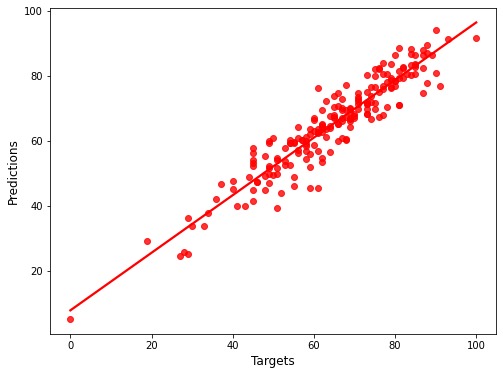

In [30]:
# scatter plot of the test set targets and predictions
plt.figure(figsize=(8, 6))
sns.regplot(x=ytest, y=yhat_test, ci=None, color="red")
plt.xlabel("Targets", fontsize=12)
plt.ylabel("Predictions", fontsize=12);

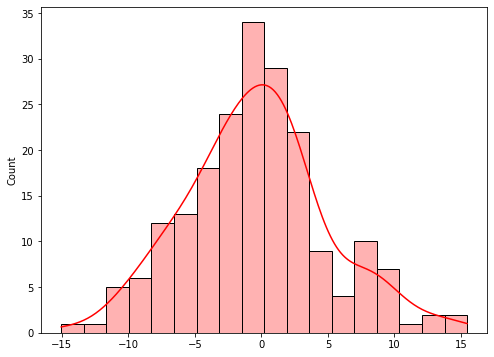

In [31]:
# distribution of test set errors
n_bins = int((1 + (3.322 * np.log(ytest.shape[0]))))
plt.figure(figsize=(8, 6))
sns.histplot(ytest-yhat_test, bins=n_bins, color="red", alpha=0.3, kde=True);

In [32]:
# output the test set adjusted R²
adj_r2 = adj_rsquared(Xtest, ytest, yhat_test)
print(f"{model_name} produced an adjusted R² of {adj_r2:.2f} for the test set.")

LinearRegression produced an adjusted R² of 0.88 for the test set.
